In [1]:
from itertools import combinations
from datetime import datetime
import math

import networkx as nx
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

In [2]:
events = pd.read_pickle('data/events_anonymized.pickle')
events['partition'] = pd.to_datetime(pd.to_datetime(events.timestamp).dt.date)

In [3]:
sampled_events = events[events.human & (events.timestamp >= datetime(2019, 1, 1)) & (events.timestamp < datetime(2020, 1, 1))]

In [4]:
sampled_events.dtypes

owner                     object
repo                      object
pull                       int64
pr_id                     object
user_id                   object
timestamp         datetime64[ns]
event                     object
source                    object
human                       bool
source_is_pr                bool
repo_full_name            object
partition         datetime64[ns]
dtype: object

In [5]:
squads = pd.read_pickle('data/squads_anonymized.pickle')

In [6]:
full_index = pd.date_range(start='2019-01-01', end='2019-12-31', freq='D')
team_mapping = squads.groupby(['userid', 'partition']).id.unique().unstack(
    level='userid').reindex(full_index).bfill().ffill().stack().reset_index()
team_mapping.rename(columns={'level_0': 'partition',
                    0: 'teams', 'userid': 'user_id'}, inplace=True)
team_mapping.teams = team_mapping.teams.apply(tuple)

In [7]:
code_reviews = pd.merge(sampled_events[['partition', 'user_id', 'pr_id']], team_mapping[['partition', 'user_id', 'teams']], on=['partition', 'user_id'], how='left')

In [8]:
code_reviews.pr_id.nunique()

220733

In [9]:
code_reviews.user_id.nunique()

2246

---

## Social Boundaries

In [10]:
participants = code_reviews.groupby('pr_id').user_id.unique().apply(tuple).rename('participants')

In [11]:
participants.str.len().value_counts(normalize=True).sort_index()

participants
1     0.248558
2     0.571437
3     0.143105
4     0.028908
5     0.006025
6     0.001377
7     0.000317
8     0.000136
9     0.000050
10    0.000027
11    0.000005
12    0.000005
13    0.000014
14    0.000009
15    0.000005
17    0.000005
18    0.000005
23    0.000009
27    0.000005
Name: proportion, dtype: float64

<Axes: xlabel='participants'>

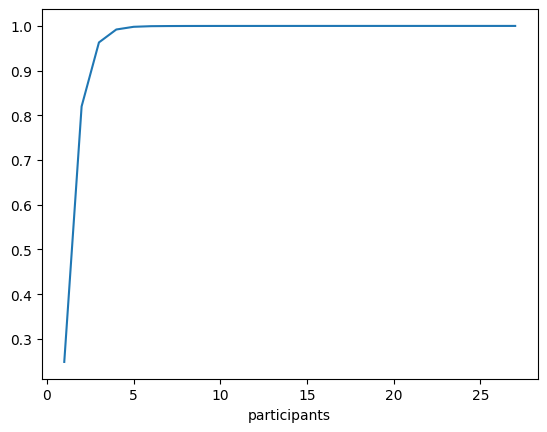

In [12]:
ecdf_participants = participants.str.len().value_counts(normalize=True).sort_index().cumsum()
ecdf_participants.to_csv('csv/ecdf_participants.csv')
ecdf_participants.plot()

In [13]:
ecdf_participants

participants
1     0.248558
2     0.819995
3     0.963100
4     0.992008
5     0.998034
6     0.999411
7     0.999728
8     0.999864
9     0.999914
10    0.999941
11    0.999946
12    0.999950
13    0.999964
14    0.999973
15    0.999977
17    0.999982
18    0.999986
23    0.999995
27    1.000000
Name: proportion, dtype: float64

In [14]:
code_reviews.pr_id.nunique()

220733

In [15]:
from collections import defaultdict


class EntityNotFound(Exception):
    pass


class Hypergraph:
    def __init__(self, hedges: dict):
        self._vertices = defaultdict(list)
        for hedge, _vertices in hedges.items():
            for vertex in _vertices:
                self._vertices[vertex] += [hedge]
        self._hedges = hedges

    def vertices(self, hedge=None):
        if hedge is None:
            return set(self._vertices)
        if hedge in self._hedges:
            return set(self._hedges[hedge])
        raise EntityNotFound(f'Unknown hyperedge {hedge}')

    def hyperedges(self, vertex=None):
        if vertex is None:
            return set(self._hedges)
        if vertex in self._vertices:
            return set(self._vertices[vertex])
        raise EntityNotFound(f'Unknown vertex {vertex}')


def jaccard_similarity(set1: set, set2: set):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union > 0 else None

In [16]:
hypergraph = Hypergraph(participants.to_dict())

In [17]:
hedge_to_idx = {label: idx for idx, label in enumerate(hypergraph.hyperedges())}

In [18]:
num_hedges = len(hypergraph.hyperedges())

In [19]:
size = num_hedges * (num_hedges - 1) // 2

In [ ]:
num_hedges = len(hypergraph.hyperedges())
similarity_matrix = np.memmap(
    'data/similarity_matrix', dtype=np.float32, mode='r', shape=(size, )) # use 'w+' if you want to compute the matrix rather than load the precomputed matrix

In [22]:
pd.Series([len(hypergraph.vertices(hedge)) for hedge in hypergraph.hyperedges()]).value_counts(normalize=True).sort_index()

1     0.248558
2     0.571437
3     0.143105
4     0.028908
5     0.006025
6     0.001377
7     0.000317
8     0.000136
9     0.000050
10    0.000027
11    0.000005
12    0.000005
13    0.000014
14    0.000009
15    0.000005
17    0.000005
18    0.000005
23    0.000009
27    0.000005
Name: proportion, dtype: float64

⚠️ Attention: The following cell is heavy work it might take some days (depending on your hardware)!

In [ ]:
total_combinations = math.comb(num_hedges, 2)
for hedge_i, hedge_j in tqdm(combinations(hypergraph.hyperedges(), 2), total=total_combinations):
    i = hedge_to_idx[hedge_i]
    j = hedge_to_idx[hedge_j]
    vertices_i = hypergraph.vertices(hedge=hedge_i)
    vertices_j = hypergraph.vertices(hedge=hedge_j)
    sim = jaccard_similarity(vertices_i, vertices_j)
    similarity_matrix[i, j] = sim
    similarity_matrix[j, i] = sim

In [23]:
counts, bins = np.histogram(similarity_matrix, bins=np.arange(0.0, 1.01, 0.01))

In [24]:
unique, frequency = np.unique(similarity_matrix, return_counts=True)

In [25]:
(pd.Series(frequency, index=unique) /
 similarity_matrix.shape[0]).cumsum().to_csv('csv/ecdf_participants.csv', float_format='%.4f', header=False)

In [26]:
print((pd.Series(frequency, index=unique)/similarity_matrix.shape[0]).cumsum())

0.000000    0.996279
0.020408    0.996279
0.022727    0.996279
0.024390    0.996279
0.025000    0.996279
              ...   
0.833333    0.999740
0.857143    0.999740
0.875000    0.999740
0.888889    0.999740
1.000000    1.000000
Length: 111, dtype: float64


In [27]:
1 - (np.count_nonzero(np.isclose(similarity_matrix, 0.0, atol=1e-8)) / pd.Series(counts).sum())

np.float64(0.0037208112830547924)

<Axes: >

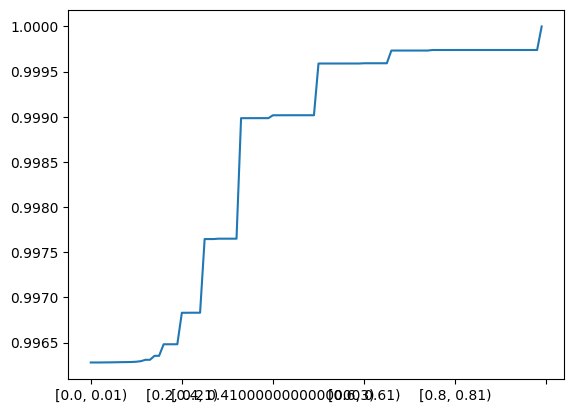

In [28]:
bin_labels = pd.IntervalIndex.from_breaks(bins, closed='left')

# Create Series
(pd.Series(counts, index=bin_labels)/np.sum(counts)).cumsum().plot()

In [29]:
cumulative_counts = np.cumsum(counts)
ecdf = cumulative_counts / cumulative_counts[-1]  # normalize to [0, 1]

In [ ]:
sampled_events.groupby('pr_id').user_id.nunique().value_counts(normalize=True).sort_index().cumsum().to_csv('csv/ecdf_participants_per_code_review.csv', header=False)

---

## Organizational Boundaries

In [ ]:
cc = {}
for pr_id, group in code_reviews.groupby('pr_id'):
    teams = group.teams.unique()
    G = nx.Graph()
    for team_combination in teams:
        if not isinstance(team_combination, float):
            for team in team_combination:
                G.add_node(team)
            G.add_edges_from(list(combinations(team_combination, 2)))
    cc[pr_id] = len(list(nx.connected_components(G)))

In [ ]:
cross_org = pd.Series(cc).value_counts(normalize=True).sort_index()

In [ ]:
cross_org.cumsum().plot()

In [ ]:
print(cross_org[cross_org.index > 1].sum(), cross_org[cross_org.index > 2].sum())

In [ ]:
cross_org.cumsum().to_csv('csv/ecdf_organizational.csv', header=False)

---

## Architectural Boundaries

In [ ]:
links = sampled_events[sampled_events['event'] == 'cross-referenced'][['pr_id', 'source']]

In [ ]:
repos = events[['pr_id', 'repo_full_name']].drop_duplicates().set_index('pr_id', verify_integrity=True)

In [ ]:
df = links.merge(repos, left_on='pr_id', right_index=True, how='left').merge(
    repos, left_on='source', right_index=True, how='left')

In [ ]:
df = df.dropna()

In [ ]:
df.pr_id.nunique(), df.pr_id.nunique()/sampled_events.pr_id.nunique()

In [ ]:
df.source.isin(sampled_events.pr_id.unique()).value_counts(normalize=True)

In [ ]:
(df.repo_full_name_x != df.repo_full_name_y).value_counts(normalize=True)

In [ ]:
df[df.repo_full_name_x == df.repo_full_name_y].repo_full_name_x.unique()